In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import urllib2
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
from pandas.stats.api import ols
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib.pyplot import cm 
import platform
import sys
import glob

import matplotlib as mpl
import matplotlib.cm as cm

import pyproj
from pyproj import Proj
import simplekml
import wellapplication as wa
#import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [2]:
import UBM

In [3]:
engineroute = "H:/Google Drive/WORK/Round_Valley/Data/"
#engineroute = "E:/PROJECTS/Groundwater Chemistry"
#engineroute = "C:/Users/Brooke/Downloads/"
sys.path.append(engineroute)
import enginegetter

In [4]:
engine = enginegetter.getEngine()

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Populate database from exported data

In [ ]:
systems = pd.read_csv('E:/sites.csv', memory_map=True)

In [ ]:
srcs = systems.SOURCE.unique()
vbls = systems.variable.unique()

for src in srcs:
    for vbl in vbls:
        df = systems[(systems['SOURCE']==src)&(systems['variable']==vbl)]
        df.to_sql(con=engine, name='zonal', if_exists='append',index=False)
        print(src, vbl)

In [ ]:
systems.head()

# Calibration

In [ ]:
def plotfits(HUC, SITE, fileloc='H:/Google Drive/WORK/UBM/'):
    from matplotlib.backends.backend_pdf import PdfPages

    HUC = [str(i) for i in HUC]
    huc10 = ["'{:}'".format(i[:-2]) for i in HUC]
    huc10 = list(set(huc10))
    
    pdf = PdfPages(fileloc+str(HUC[0])[:-2]+'.pdf')
    
    quer = "SELECT HUC_12,YearMonth,volume_acft FROM ubm.bdgt WHERE SOURCE = '{:}' AND HUC_10 IN({:}) AND variable IN('{:}')"
    dataset = 'UBM'
    variable = 'recharge'
    Urc = pd.read_sql_query(sql=quer.format(dataset,','.join(huc10),variable),con=engine)
    variable = 'runoff'
    Urn = pd.read_sql_query(sql=quer.format(dataset,','.join(huc10),variable),con=engine)

    Urun = Urn[Urn['HUC_12'].isin(HUC)]
    Urun = Urun.rename(columns={'volume_acft':'runoff_acft'})
    Urun.set_index(['HUC_12','YearMonth'],inplace=True)
    Urec = Urc[Urc['HUC_12'].isin(HUC)]
    Urec = Urec.rename(columns={'volume_acft':'recharge_acft'})
    Urec.set_index(['HUC_12','YearMonth'],inplace=True)

    UBM = pd.concat([Urun,Urec], axis =1)
    UBM['dt'] = pd.to_datetime(UBM.index.get_level_values(1),errors='coerce',format='%Y%m')

    UBM.reset_index(inplace=True)
    UBM.dropna(inplace=True)
    UBMgrp = UBM.groupby(['dt']).sum()

    # Grab USGS data for comparison
    nw = wa.nwis('dv',SITE,'sites', startDT='2003-01-01')
    data = nw.data
    Label = nw.sites.station_nm[0].title()
    data['cfd'] = data.value * 86400 #cfs to cfd
    if isinstance(data.index, pd.core.index.MultiIndex):
        data.index = data.index.droplevel(0)
    # convert to acft by converting from monthly sum of cfd to acft-mo
    acft = data['cfd'].groupby(pd.TimeGrouper('MS', label='left')).sum() * 2.29569E-5
    acft = acft.to_frame()
    
    # get monthly average values (plot 2)
    # Model
    UBMgrp['month'] = UBMgrp.index.month
    UBMmon = UBMgrp.groupby(['month']).mean()
    # USGS data
    acft['month'] = acft.index.month 
    acgp = acft.groupby('month').mean()
    
    plt.figure()
    plt.plot(UBMgrp.index, UBMgrp.recharge_acft, 'o-', label='Modeled Recharge')
    plt.plot(UBMgrp.index, UBMgrp.runoff_acft, 'o-', label='Modeled Runoff' )
    plt.plot(acft.index,acft['cfd'],'o-',label='Measured Surface Discharge')
    plt.ylabel('Discharge (ac-ft)')
    plt.legend()
    plt.title(Label +' '+ str(SITE))
    plt.grid()
    pdf.attach_note(Label)  
    pdf.savefig()
    plt.close()
    
    plt.figure()
    plt.plot(UBMmon.index, UBMmon.recharge_acft, 'o-', label='Modeled Recharge')
    plt.plot(UBMmon.index, UBMmon.runoff_acft, 'o-', label='Modeled Runoff' )
    plt.plot(acgp.index, acgp,'o-',label='Measured Surface Discharge')
    plt.ylabel('Discharge (ac-ft)')
    plt.legend()
    plt.title(Label +' '+ str(SITE))
    plt.grid()
    pdf.attach_note(Label)  
    pdf.savefig()
    plt.close()
    
    # This section pulls the individual model inputs and plots them (third figure)
    quer = "SELECT HUC_12,YearMonth,volume_acft,SOURCE,AREA,variable FROM ubm.bdgt WHERE HUC_10 IN({:}) AND SOURCE IN({:})"
    sources = "'Surrgo','State Geologic Maps','SNODAS','MODIS16'"

    chk = pd.read_sql_query(sql=quer.format(','.join(huc10),sources),con=engine)
    chk = chk[chk['HUC_12'].isin(HUC)]
    chk['dt'] = pd.to_datetime(chk.YearMonth,errors='coerce',format='%Y%m')

    piv = pd.pivot_table(chk, index=['HUC_12','dt'], columns='variable', values='volume_acft')
    pv = pd.pivot_table(chk, index=['HUC_12'], columns='variable', values='volume_acft')
    pv.drop([u'evapotranspiration', u'precip as rain', u'snowmelt'],inplace=True,axis=1)
    piv.reset_index(inplace=True)
    pv.reset_index(inplace=True)
    mrg1 = pd.merge(piv,pv, on='HUC_12')
    mrg1.reset_index(inplace=True)

    areas = chk.drop(['YearMonth','SOURCE','variable','volume_acft','dt'],axis=1)
    areas.drop_duplicates(inplace=True)
    mrg = pd.merge(mrg1, areas, on='HUC_12')
    mrg.dropna(inplace=True)
    
    #mrg.set_index(['HUC_12','dt'],inplace=True)

    mrg['incoming_water'] = mrg[u'precip as rain']+mrg[u'snowmelt']
    mrg_grp = mrg.groupby(['dt']).agg([np.sum,np.mean])
    #mrg_grp = mrg.groupby(['dt']).agg(np.sum)

    mrg_grp.drop(['AREA','index', u'precip as rain', u'snowmelt','porosity'],inplace=True,axis=1)
    if isinstance(mrg_grp.index, pd.core.index.MultiIndex):
        mrg_grp.index = mrg_grp.index.droplevel(0)
    mrg_grp.drop([('evapotranspiration','mean'),('incoming_water','mean'),
              ('field capacity','sum'),('total soil moisture','sum'),
              ('wilting point','sum'),('conductivity','sum')],axis=1,inplace=True)
    mrg_grp.columns = mrg_grp.columns.droplevel(-1)

    mrg_grp.plot()
    plt.text('1/1/2009',mrg_grp['total soil moisture'].median(),'Max Soil Capacity')
    plt.text('1/1/2009',mrg_grp['wilting point'].median(),'Wilting Point')
    plt.text('1/1/2009',mrg_grp['field capacity'].median(),'Field Capacity')
    plt.text('1/1/2009',mrg_grp['conductivity'].median(),'Geologic K')
    plt.legend(loc=1)
    plt.ylabel('ac-ft') 
    plt.title(Label +' '+ str(SITE))
    pdf.attach_note(Label)  
    pdf.savefig()
    plt.close()
    pdf.close()
    
    
    mrg.set_index(['dt'], inplace=True)
    mrg.drop('index', inplace=True,axis=1)
    mrg['YearMonth'] = [str(x.year) + str(x.month).zfill(2) for x in mrg.index]
    mrg1 = pd.merge(UBM, mrg, on=['HUC_12','YearMonth'])
    mrg1.set_index(['dt'], inplace=True)
    
    return UBM, acft, UBMmon, acgp, mrg1

In [ ]:
mrg1 = pd.merge(UBM,mrg,on=['HUC_12','YearMonth'])
mrg

In [ ]:
mrg

## S. Fork Ogden River

In [6]:
import UBM

In [7]:
HUC = ['160201020204','160201020203','160201020205','160201020202','160201020201']
SITE = 10137500
Label = 'S. Fork Ogden River'
fileloc = 'U:/GWP/Groundwater/Projects/BCM/Graphs/'
table = 'zonebudgets'
ubm, acft, ubmmon, acgp, mrg = UBM.plotfits(HUC,SITE,engine,fileloc,table)

connection successful


In [16]:
ubmdata = UBM.get_UBM_data(HUC, engine, table)

In [18]:
modin = UBM.get_model_inputs(HUC,engine,table)

In [21]:
modout = UBM.runModel(modin)
modout.to_clipboard()

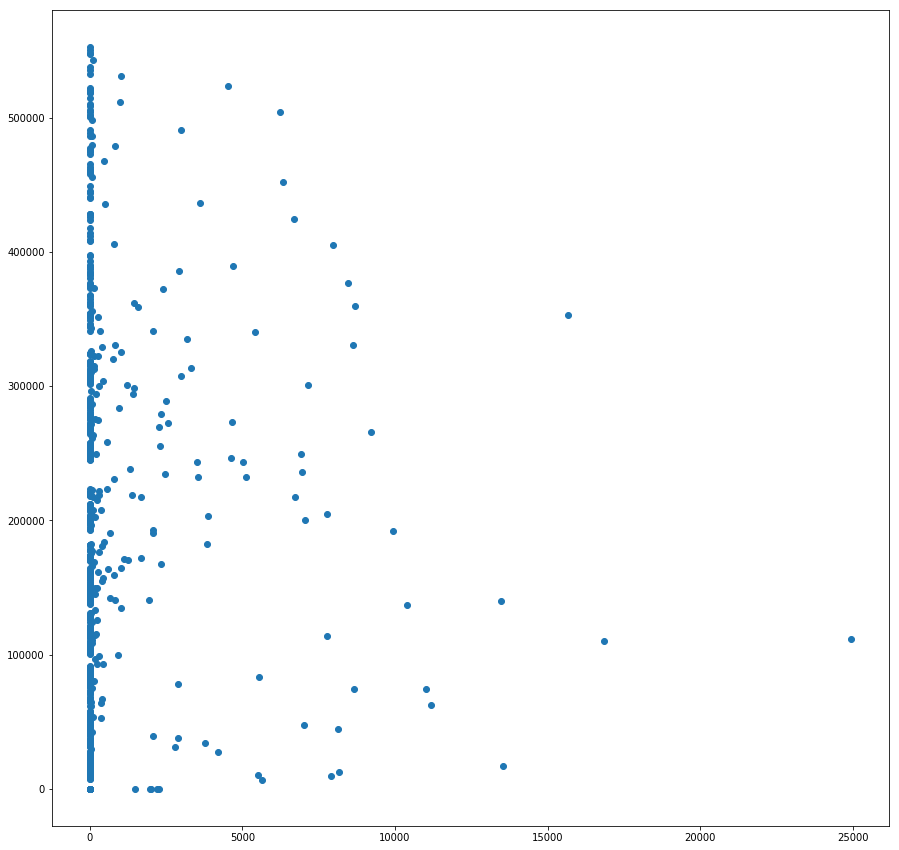

In [10]:
df = UBM.runModel(mrg)
x = df['runoff_acft']
y = df['runoff']

plt.scatter(x,y)

## Chalk Creek

In [ ]:
HUC = [160202010307, 160202010304, 160202010306, 160202010305, 160202010303, 160202010302, 160202010301]
SITE = 10131000
Label = 'Chalk Creek'

UBM, acft, UBMmon, acgp, mrg = plotfits(HUC,SITE,Label)

## Logan River

In [ ]:
HUC = [160102030303,160102030305,160102030307,160102030306,160102030302,160102030304,160102030301]
SITE = 10109000
SITE1 = 10109001

UBM, acft, UBMmon, acgp, mrg = plotfits(HUC,SITE)

## Blacksmith Fork

In [ ]:
HUC = [160102030203,160102030201,160102030204,160102030202,160102030205,160102030208,160102030206,160102030207]
SITE = 10113500 
Label = 'Blacksmith Fork'
UBM, acft, UBMmon, acgp, mrg = plotfits(HUC,SITE,Label)

## Currant Creek

In [ ]:
[160202010105,160202010102,160202010103,160202010104,160202010107,160202010101,160202010106]
10146400

In [ ]:
[160202010105,160202010103,160202010104]
10146000

## Multiple Basins

In [ ]:
sitesHUCs = {10150500:[160202020105,160202020104,160202020306,160202020103,160202020305,160202020303,160202020302,160202020301,
                       160202020501,160202020307,160202020202,160202020201,160202020101,160202020204,160202020304,160202020205,
                       160202020106,160202020203,160202020102,160202020107], 10146000:[160202010105,160202010103,160202010104], 
             10146400:[160202010105,160202010102,160202010103,160202010104,160202010107,160202010101,160202010106],
             10113500:[160102030203,160102030201,160102030204,160102030202,160102030205,160102030208,160102030206,160102030207],
             10109000:[160102030303,160102030305,160102030307,160102030306,160102030302,160102030304,160102030301],
             10131000:[160202010307,160202010304,160202010306,160202010305,160202010303,160202010302,160202010301],
             10137500:[160201020204,160201020203,160201020205,160201020202,160201020201],
             10149400:[160202020303,160202020302,160202020301,160202020304], 
             10149000:[160202020301],
             '09288000':[140600040403,140600040402,140600040401,140600040404],
             '09285900':[140600040103,140600040304,140600040104,140600040106,140600040105,140600040301,140600040303,
                         140600040101,140600040102,140600040302],
             '09288180':[140600040506,140600040103,140600040802,140600040503,140600040304,140600040504,140600040801,
                         140600040201,140600040203,140600040804,140600040405,140600040403,140600040402,140600040204,
                         140600040202,140600040501,140600040401,140600040502,140600040104,140600040106,140600040105,
                         140600040805,140600040301,140600040303,140600040101,140600040102,140600040302,140600040404,
                         140600040505,140600040803],
             '09326500':[140600090302,140600090301,140600090303],
             '09405500':[150100080104,150100080103,150100080102,150100080106,150100080101,150100080108,150100080107,
                         150100080105,150100080109],
             '09409880':[150100080603,150100080702,150100080704,150100080701,150100080802,150100080703,150100080601,
                         150100080602],
             '09409100':[150100080702,150100080701,150100080703],
             '09414900':[150100100101,150100100102,150100100202,150100100205,150100100105,150100100207,150100100109,
                         150100100110,150100100208,150100100104,150100100206,150100100204,150100100106,150100100107,
                         150100100108,150100100203,150100100103],
             10166430:[160202010701],
             10128500:[160201010205,160201010204,160201010203,160201010206,160201010201,160201010202]}



In [ ]:
{10174500:[160300010101,160300010202,160300010203,160300010302,160300010301,160300010103,
          160300010102,160300010201,160300010303,160300010104,160300010204,160300010105],
'09408195':[150100090601,150100090603,150100090408,150100090604,150100090602],
             10215900:[1603000306],
             '09406000':[150100080209,150100080506,150100080505,150100080504,150100080207,150100080503,150100080104,
                         150100080103,150100080204,150100080102,150100080201,150100080502,150100080507,150100080106,
                         150100080208,150100080101,150100080205,150100080202,150100080108,150100080206,150100080107,
                         150100080203,150100080105,150100080109,150100080210],}

In [ ]:
for key,values in sitesHUCs.iteritems():
    print(key)
    UBM, acft, UBMmon, acgp, mrg = plotfits(values,key)

In [ ]:
mrg.set_index(['HUC_12','dt'],inplace=True)

In [ ]:
mrg['YearMonth'] = [str(x.year) + str(x.month).zfill(2) for x in mrg.index]

In [ ]:
huc12list = mrg.index.get_level_values(0)

mrg['avail_water'] = np.nan
mrg['avail_rech'] = np.nan
mrg['aet'] = np.nan
mrg['runoff'] = np.nan
mrg['recharge'] = np.nan


for huc, grp in mrg.groupby(level=0):
    
    grp.ix[grp.index.min(),'avail_water'] = grp.ix[0,'precip as rain'] + grp.ix[0,'snowmelt'] + grp['field capacity'].mean()
    soil_max = grp['total soil moisture'].mean()
    field_cap = grp['field capacity'].mean()
    geo_k = grp['conductivity'].mean()
    wilt_pnt = grp['wilting point'].mean()
    
    for i, sub in grp.groupby(level=0):

        sub.ix[i,'test'] = i
        rain = sub.ix[i,'precip as rain']
        melt = sub.ix[i,'snowmelt']
        pet = sub.ix[i, 'evapotranspiration']

        if i == grp.index.min():
            sub.ix[i,'avail_water'] = rain + melt + field_cap
        else:    
            sub.ix[i,'avail_water'] = rain + melt + sub.ix[i.shift(-1

In [ ]:
mrg.drop('index',inplace=True,axis=1)

In [ ]:
mrg.set_index(['dt'],inplace=True)
mrg.drop('index',inplace=True,axis=1)

In [ ]:
UBMplus = pd.merge(UBM, df, on=['HUC_12','YearMonth'])



In [ ]:
UBMplus.to_clipboard()

In [ ]:
x = UBMplus.recharge
y = UBMplus.recharge_acft

plt.scatter(x,y)

In [ ]:
def runModel(mrg, geo_k=''):
    huc12list = mrg['HUC_12'].unique()

    mrg['avail_water'] = np.nan
    mrg['avail_rech'] = np.nan
    mrg['aet'] = np.nan
    mrg['runoff'] = np.nan
    mrg['recharge'] = np.nan
    mrg['eqt'] = np.nan

    grp = {}

    for h in huc12list:

        grp[h] = mrg[mrg['HUC_12']==h]
        grp[h] = grp[h][~grp[h].index.duplicated(keep='first')]

        soil_max = grp[h]['porosity'].mean()
        field_cap = grp[h]['field capacity'].mean()
        if geo_k == '':
            geo_k = grp[h]['conductivity'].mean()
    
        wilt_pnt = grp[h]['wilting point'].mean()
        dates = pd.date_range(start=grp[h].index.min(),end=grp[h].index.max(),freq='MS')

        for i in dates:
            rain = grp[h].ix[i,'precip as rain']
            melt = grp[h].ix[i,'snowmelt']
            pet = grp[h].ix[i,'evapotranspiration']
            if i == dates[0]:
                avail_water = rain + melt + field_cap
            elif i.month == 1:    
                avail_water = rain + melt + grp[h].ix[pd.datetime(i.year-1,12,1),'avail_water']
            else:
                avail_water = rain + melt + grp[h].ix[pd.datetime(i.year,i.month-1,1),'avail_water']

            if avail_water > soil_max:

                avail_rech = soil_max - field_cap
                grp[h].ix[i, 'aet'] = pet

                if avail_rech > geo_k:
                    grp[h].ix[i,'eqt'] = 1.1

                    grp[h].ix[i,'runoff'] = (avail_water - soil_max) + (avail_rech - geo_k)
                    grp[h].ix[i,'recharge'] = geo_k
                else:
                    grp[h].ix[i,'eqt'] = 1.2
                    grp[h].ix[i,'runoff'] = avail_water - soil_max
                    grp[h].ix[i,'recharge'] = avail_rech
            elif (avail_water < soil_max) and (avail_water > field_cap):
                grp[h].ix[i,'eqt'] = 2
                avail_rech = avail_water - field_cap
                grp[h].ix[i, 'aet'] = pet

                if avail_rech > geo_k:
                    grp[h].ix[i,'runoff'] = avail_rech - geo_k
                    grp[h].ix[i,'recharge'] = geo_k
                else:
                    grp[h].ix[i,'runoff'] = 0
                    grp[h].ix[i,'recharge'] = avail_rech
            elif (avail_water > wilt_pnt) and (avail_water < field_cap):
                grp[h].ix[i,'eqt'] = 3
                grp[h].ix[i,'runoff'] = 0
                grp[h].ix[i,'recharge'] = 0
                grp[h].ix[i, 'aet'] = pet        
            elif avail_water < wilt_pnt:
                grp[h].ix[i,'eqt'] = 4
                grp[h].ix[i,'runoff'] = 0
                grp[h].ix[i,'recharge'] = 0
                grp[h].ix[i, 'aet'] = 0
            else:
                pass

            grp[h].ix[i, 'avail_rech'] = avail_rech
            grp[h].ix[i,'avail_water'] = avail_water


    if len(huc12list) > 1:
        df = pd.concat([grp[h] for h in huc12list])

    else:
        df = grp[h]
    df['YearMonth'] = [str(x.year) + str(x.month).zfill(2) for x in df.index]

    return df


In [ ]:
df['YearMonth']

In [ ]:
from scipy.interpolate import griddata
import matplotlib.cm as cm


SITE = '10131000'
meth = 'linear'#'nearest'

nw = wa.nwis('dv',SITE,'sites')#, startDT='1999-01-01')
data = nw.data
if isinstance(data.index, pd.core.index.MultiIndex):
    data.index = data.index.droplevel(0)
    
x = data.index.dayofyear
y = data.index.year
z = data.value.values

xi = np.linspace(x.min(), x.max(), 1000)
yi = np.linspace(y.min(), y.max(), 1000)
zi = griddata((x,y),z,(xi[None,:],yi[:,None]),method=meth)


cmap = plt.cm.get_cmap('RdYlBu')
norm = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(z)


br = plt.contourf(xi,yi,zi,color=m.to_rgba(z),cmap=cmap)
# setup the colorbar


cbar = plt.colorbar(m)
cbar.set_label('Discharge (cfs)')

plt.xlabel('Month')
plt.ylabel('Year')
plt.yticks(range(y.min(),y.max()))

mons = {'Apr': 90.25, 'Aug': 212.25, 'Dec': 334.25, 'Feb': 31, 'Jan': 1, 'Jul': 181.25, 'Jun': 151.25, 'Mar': 59.25, 'May': 120.25,
 'Nov': 304.25, 'Oct': 273.25, 'Sep': 243.25}
monnms = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.title(nw.sites.station_nm[0].title())
tickplc = []
plt.xticks([mons[i] for i in monnms], monnms)
print(y.max())
plt.grid()